In [ ]:
import sys
sys.path.append('../')

import gc
import yaml
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from networks import define_G
from pipeline import AlignedDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
with open("../configs/sdo/unet_patchgan.yaml") as file:
    cfg = yaml.safe_load(file)
    data = cfg['data']

G = define_G(cfg)

G.load_state_dict(
    torch.load("../results/sdo/default_lightning/logs/version_2/checkpoints/49_12050_G.pth", weights_only=True)
)

G = G.to(device)

initialize network with normal


In [ ]:
val_dataset = AlignedDataset(
    input_dir=data['val']['input_dir'], 
    target_dir=data['val']['target_dir'],
    image_size=data['image_size'],
    ext=data['ext']
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=data['val']['batch_size'], 
    shuffle=data['val']['shuffle'],
    num_workers=data['val']['num_workers'],
    pin_memory=False,
    drop_last=data['val']['drop_last']
)

test_dataset = AlignedDataset(
    input_dir=data['test']['input_dir'], 
    target_dir=data['test']['target_dir'],
    image_size=data['image_size'],
    ext=data['ext']
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=data['test']['batch_size'], 
    shuffle=data['test']['shuffle'],
    num_workers=data['test']['num_workers'],
    pin_memory=False,
    drop_last=data['test']['drop_last']
)

In [ ]:
from tqdm import tqdm
from torchmetrics import MeanAbsoluteError
from torchmetrics.regression import PearsonCorrCoef
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

def calculate_metrics(model, loader, device, binning=4, stage="Validation"):
    model.eval()
    with torch.no_grad():
        mae = MeanAbsoluteError().to(device)                  # 0.0 is best
        psnr = PeakSignalNoiseRatio().to(device)              # +inf is best
        ssim = StructuralSimilarityIndexMeasure().to(device)  # 1.0 is best
        pearson = PearsonCorrCoef().to(device)                # 1.0 is best
        
        maes = []
        psnrs = []
        ssims = []
        pearsons = []

        avgpool2d = torch.nn.AvgPool2d(binning)
        maes_binning = []
        psnrs_binning = []
        ssims_binning = []
        pearsons_binning = []

        for i, (inputs, real_target) in enumerate(tqdm(loader, desc=stage)):
            inputs = inputs.to(device)
            real_target = real_target.to(device)
            fake_target = model(inputs)
            if i == 0:
                fig = val_dataset.create_figure(inputs[0], real_target[0], fake_target[0])
                plt.show()
                print(inputs.shape)
                print(real_target.shape)
                print(fake_target.shape)
            
            mae_value = mae(fake_target, real_target)
            pixel_to_pixel_cc = pearson(fake_target.flatten(), real_target.flatten())
            psnr_value = psnr(fake_target, real_target)
            ssim_value = ssim(fake_target, real_target)

            maes.append(mae_value)
            psnrs.append(psnr_value)
            ssims.append(ssim_value)
            pearsons.append(pixel_to_pixel_cc)

            mae.reset()
            pearson.reset()
            psnr.reset()
            ssim.reset()
            
            inputs_binning = avgpool2d(inputs)
            real_target_binning = avgpool2d(real_target)
            fake_target_binning = avgpool2d(fake_target)
            if i == 0:
                fig = val_dataset.create_figure(inputs[0], real_target_binning[0], fake_target_binning[0])
                plt.show()
                print(inputs_binning.shape)
                print(real_target_binning.shape)
                print(fake_target_binning.shape)
                
            mae_value_binning = mae(fake_target_binning, real_target_binning)
            pixel_to_pixel_cc_binning = pearson(fake_target_binning.flatten(), real_target_binning.flatten())
            psnr_value_binning = psnr(fake_target_binning, real_target_binning)
            ssim_value_binning = ssim(fake_target_binning, real_target_binning)

            maes_binning.append(mae_value_binning)
            psnrs_binning.append(psnr_value_binning)
            ssims_binning.append(ssim_value_binning)
            pearsons_binning.append(pixel_to_pixel_cc_binning)
            
            mae.reset()
            psnr.reset()
            ssim.reset()
            pearson.reset()

            del inputs
            del real_target
            del fake_target
            del inputs_binning
            del real_target_binning
            del fake_target_binning

            gc.collect()
            torch.cuda.empty_cache()

    mae = sum(maes) / len(maes)
    psnr = sum(psnrs) / len(psnrs)
    ssim = sum(ssims) / len(ssims)
    pearson = sum(pearsons) / len(pearsons)

    mae_binning = sum(maes_binning) / len(maes_binning)
    psnr_binning = sum(psnrs_binning) / len(psnrs_binning)
    ssim_binning = sum(ssims_binning) / len(ssims_binning)
    pearson_binning = sum(pearsons_binning) / len(pearsons_binning)

    return {
        "MAE": mae,
        "PSNR": psnr,
        "SSIM": ssim,
        "Pearson": pearson,
        "MAE_binning": mae_binning,
        "PSNR_binning": psnr_binning,
        "SSIM_binning": ssim_binning,
        "Pearson_binning": pearson_binning
    }

Validation:   0%|          | 0/243 [00:00<?, ?it/s]

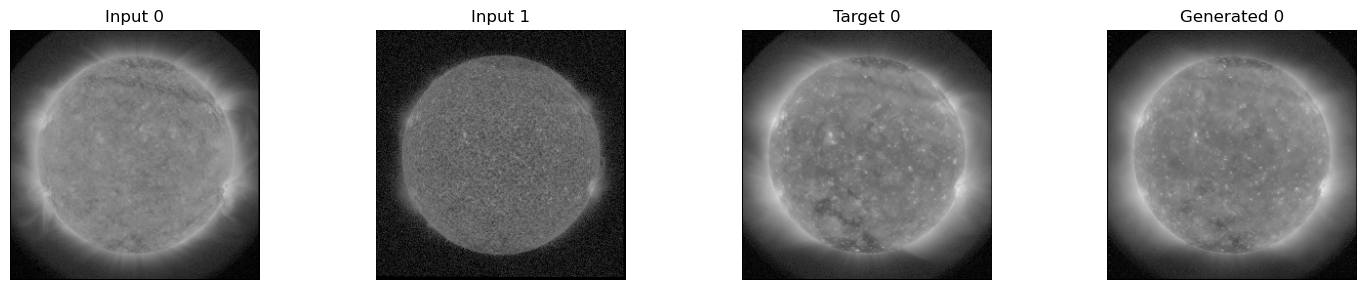

torch.Size([1, 2, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


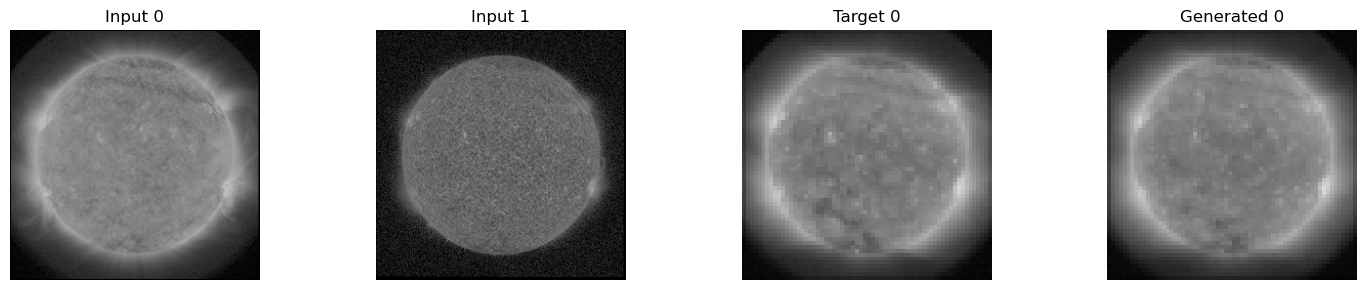

torch.Size([1, 2, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


Validation: 100%|██████████| 243/243 [00:31<00:00,  7.60it/s]

Validation MAE: 0.04
Validation PSNR: 30.15
Validation SSIM: 0.72
Validation Pixel-to-pixel Pearson CC: 0.99
Validation MAE (4x4): 0.03
Validation PSNR (4x4): 31.53
Validation SSIM (4x4): 0.85
Validation Pixel-to-pixel Pearson CC (4x4): 0.99


In [ ]:
binning = 4

val_metrics = calculate_metrics(G, val_loader, device, stage="Validation", binning=binning)
print(f"Validation MAE: {val_metrics['MAE']:.2f}")
print(f"Validation PSNR: {val_metrics['PSNR']:.2f}")
print(f"Validation SSIM: {val_metrics['SSIM']:.2f}")
print(f"Validation Pixel-to-pixel Pearson CC: {val_metrics['Pearson']:.2f}")
print(f"Validation MAE ({binning}x{binning}): {val_metrics['MAE_binning']:.2f}")
print(f"Validation PSNR ({binning}x{binning}): {val_metrics['PSNR_binning']:.2f}")
print(f"Validation SSIM ({binning}x{binning}): {val_metrics['SSIM_binning']:.2f}")
print(f"Validation Pixel-to-pixel Pearson CC ({binning}x{binning}): {val_metrics['Pearson_binning']:.2f}")

Test:   0%|          | 0/244 [00:00<?, ?it/s]

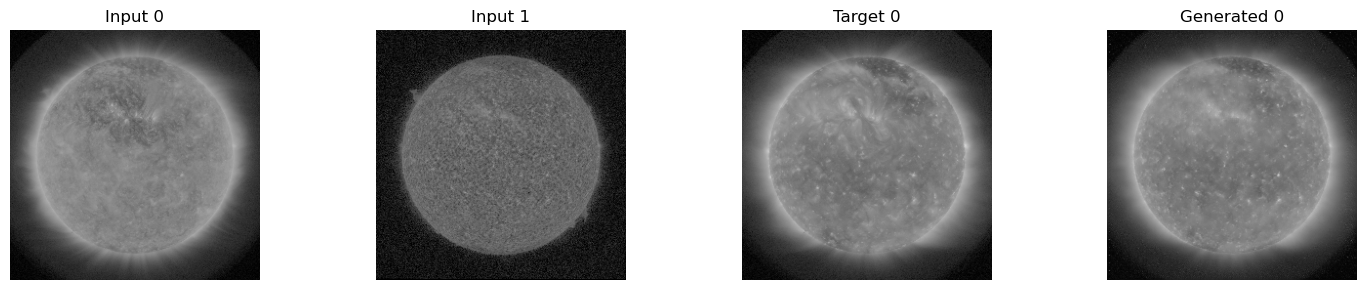

torch.Size([1, 2, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


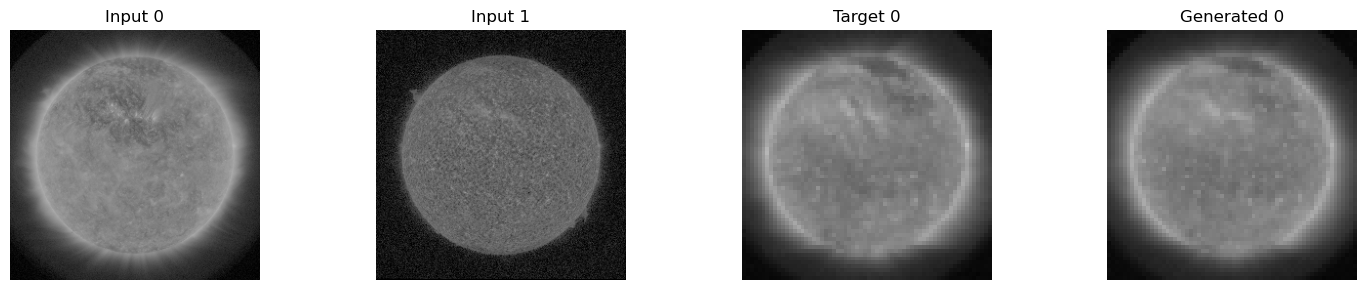

torch.Size([1, 2, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


Test: 100%|██████████| 244/244 [00:33<00:00,  7.30it/s]

Test MAE: 0.04
Test PSNR: 29.94
Test SSIM: 0.70
Test Pixel-to-pixel Pearson CC: 0.99
Test MAE (4x4): 0.03
Test PSNR (4x4): 31.21
Test SSIM (4x4): 0.84
Test Pixel-to-pixel Pearson CC (4x4): 0.99


In [ ]:
binning = 4
test_metrics = calculate_metrics(G, test_loader, device, stage="Test", binning=binning)
print(f"Test MAE: {test_metrics['MAE']:.2f}")
print(f"Test PSNR: {test_metrics['PSNR']:.2f}")
print(f"Test SSIM: {test_metrics['SSIM']:.2f}")
print(f"Test Pixel-to-pixel Pearson CC: {test_metrics['Pearson']:.2f}")
print(f"Test MAE ({binning}x{binning}): {test_metrics['MAE_binning']:.2f}")
print(f"Test PSNR ({binning}x{binning}): {test_metrics['PSNR_binning']:.2f}")
print(f"Test SSIM ({binning}x{binning}): {test_metrics['SSIM_binning']:.2f}")
print(f"Test Pixel-to-pixel Pearson CC ({binning}x{binning}): {test_metrics['Pearson_binning']:.2f}")